# 📌 Step 1: Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 📌 Step 2: Define data folder path (update this to your "data" folder path)

In [2]:
data_folder = "data"

# 📌 Step 3: Load all CSV files from multiple subfolders

In [3]:
all_files = []
for root, dirs, files in os.walk(data_folder):
    for file in files:
        if file.endswith(".csv"):
            all_files.append(os.path.join(root, file))

print(f"Found {len(all_files)} CSV files.")

Found 1504 CSV files.


# 📌 Step 4: Read and merge all CSVs

In [4]:
df_list = []
for f in all_files:
    try:
        temp = pd.read_csv(f)
        temp['source_file'] = os.path.basename(f)   # track which file it came from
        df_list.append(temp)
    except Exception as e:
        print(f"Error reading {f}: {e}")

df = pd.concat(df_list, ignore_index=True)
print("Final merged dataset shape:", df.shape)

Final merged dataset shape: (13175040, 14)


# 📌 Step 5: Quick overview

In [5]:
print(df.head())
print(df.info())
print(df.describe())

          Date/Time  Electricity:Facility [kW](Hourly)  \
0   01/01  01:00:00                          22.035977   
1   01/01  02:00:00                          14.649757   
2   01/01  03:00:00                          14.669567   
3   01/01  04:00:00                          14.677808   
4   01/01  05:00:00                          14.824794   

   Fans:Electricity [kW](Hourly)  Cooling:Electricity [kW](Hourly)  \
0                       3.586221                               0.0   
1                       0.000000                               0.0   
2                       0.000000                               0.0   
3                       0.000000                               0.0   
4                       0.000000                               0.0   

   Heating:Electricity [kW](Hourly)  InteriorLights:Electricity [kW](Hourly)  \
0                               0.0                                 4.589925   
1                               0.0                                 1.

# 📌 Step 6: Handle datetime (assuming there’s a 'timestamp' column)

In [6]:
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df.dropna(subset=['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour
    df['month'] = df['timestamp'].dt.month

# 📌 Step 7: Missing values check

In [7]:
missing = df.isnull().sum()
print("Missing values:\n", missing)

Missing values:
 Date/Time                                            0
Electricity:Facility [kW](Hourly)                    0
Fans:Electricity [kW](Hourly)                        0
Cooling:Electricity [kW](Hourly)                     0
Heating:Electricity [kW](Hourly)                     0
InteriorLights:Electricity [kW](Hourly)              0
InteriorEquipment:Electricity [kW](Hourly)           0
Gas:Facility [kW](Hourly)                            0
Heating:Gas [kW](Hourly)                             0
InteriorEquipment:Gas [kW](Hourly)             5764080
Water Heater:WaterSystems:Gas [kW](Hourly)     2470320
source_file                                          0
Electricity:Facility [kW](Monthly)            13175040
Gas:Facility [kW](Monthly)                    13175040
dtype: int64


# 📌 Step 8: Daily consumption trend

In [8]:
if 'energy_kwh' in df.columns:
    daily_trend = df.groupby('date')['energy_kwh'].sum()
    plt.figure(figsize=(12,5))
    daily_trend.plot()
    plt.title("Daily Energy Consumption Trend")
    plt.xlabel("Date")
    plt.ylabel("Total kWh")
    plt.show()

# 📌 Step 9: Hourly usage pattern

In [9]:
if 'energy_kwh' in df.columns:
    hourly_pattern = df.groupby('hour')['energy_kwh'].mean()
    plt.figure(figsize=(10,5))
    hourly_pattern.plot(kind='bar')
    plt.title("Average Hourly Energy Consumption")
    plt.xlabel("Hour of Day")
    plt.ylabel("Avg kWh")
    plt.show()

# 📌 Step 10: Building type comparison

In [10]:
if 'building_type' in df.columns and 'energy_kwh' in df.columns:
    building_usage = df.groupby('building_type')['energy_kwh'].mean().sort_values()
    plt.figure(figsize=(10,5))
    building_usage.plot(kind='bar')
    plt.title("Average Energy Consumption by Building Type")
    plt.xlabel("Building Type")
    plt.ylabel("Avg kWh")
    plt.show()

# 📌 Step 11: Correlation analysis (numerical columns)

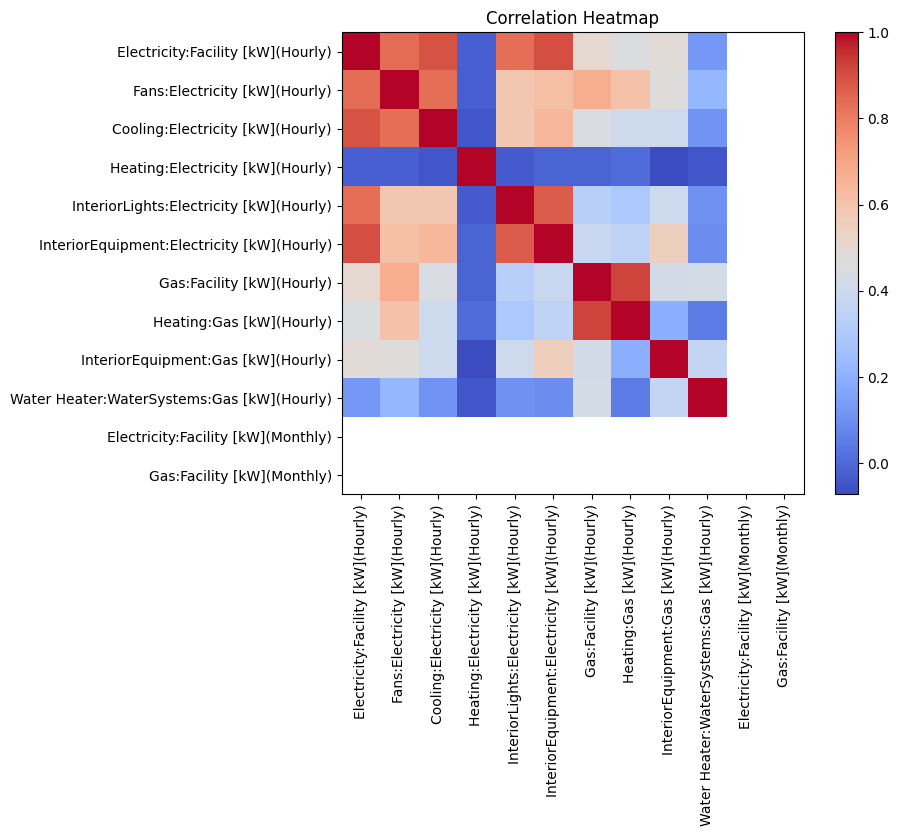

In [11]:
numeric_cols = df.select_dtypes(include=np.number)
plt.figure(figsize=(8,6))
plt.imshow(numeric_cols.corr(), cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(numeric_cols.columns)), numeric_cols.columns, rotation=90)
plt.yticks(range(len(numeric_cols.columns)), numeric_cols.columns)
plt.title("Correlation Heatmap")
plt.show()

# 📌 Step 12: Insights summary

In [12]:
print("\n🔍 Key Insights:")
if 'energy_kwh' in df.columns:
    print(f"- Peak usage hour: {hourly_pattern.idxmax()} (avg {hourly_pattern.max():.2f} kWh)")
    print(f"- Lowest usage hour: {hourly_pattern.idxmin()} (avg {hourly_pattern.min():.2f} kWh)")
    print(f"- Highest consuming building type: {building_usage.idxmax()} ({building_usage.max():.2f} kWh avg)")
    print(f"- Lowest consuming building type: {building_usage.idxmin()} ({building_usage.min():.2f} kWh avg)")


🔍 Key Insights:


In [13]:
import pandas as pd

def parse_datetime_column(df, col="Date/Time"):
    """
    Clean and robustly parse the Date/Time column.
    """
    # Convert to string and remove extra spaces
    dt = df[col].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()

    # Check if year exists (e.g., "2024/01/01 01:00:00" vs "01/01 01:00:00")
    has_year = dt.str.match(r"^\d{4}")

    # Add dummy year (2024) if missing
    dt = dt.where(has_year, "2024/" + dt)

    # Parse datetime
    df[col] = pd.to_datetime(dt, errors="coerce")

    # Drop rows where datetime parsing failed
    df = df.dropna(subset=[col])
    return df

# ------------------- USAGE -------------------

# Load CSV
df = pd.read_csv(r"preprocessing\commercial.csv")

# Parse datetime safely
df = parse_datetime_column(df, "Date/Time")

# Identify energy columns (exclude Date/Time)
energy_cols = [col for col in df.columns if col != 'Date/Time']

# Convert energy columns to numeric (strings -> floats, errors -> NaN)
df[energy_cols] = df[energy_cols].apply(pd.to_numeric, errors='coerce')

# Sum row-wise to get total energy per timestamp
df['energy_kwh'] = df[energy_cols].sum(axis=1)

# Hourly average energy consumption
hourly_pattern = df.groupby(df['Date/Time'].dt.hour)['energy_kwh'].mean()

# ------------------- OUTPUT -------------------
print("\n🔍 Key Insights:")
print(f"- Peak usage hour: {hourly_pattern.idxmax()} (avg {hourly_pattern.max():.2f} kWh)")
print(f"- Lowest usage hour: {hourly_pattern.idxmin()} (avg {hourly_pattern.min():.2f} kWh)")



🔍 Key Insights:
- Peak usage hour: 8 (avg 721.92 kWh)
- Lowest usage hour: 3 (avg 293.10 kWh)


# Visualization for the hourly energy usage using matplotlib and seaborn

C:\Users\gupta\AppData\Local\Temp\ipykernel_12072\1463556346.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_pattern.index, y=hourly_pattern.values, palette="viridis")


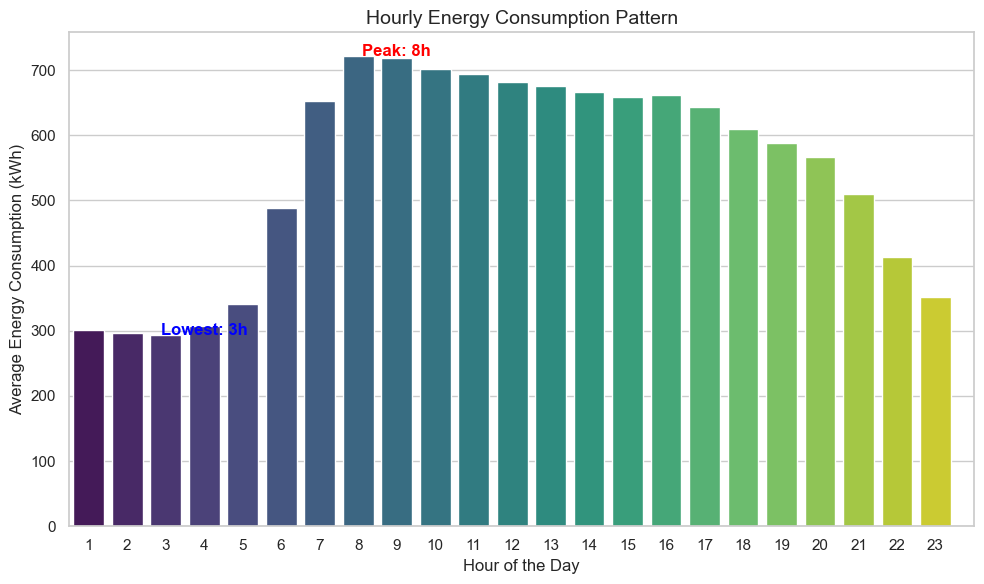

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Create a bar plot of hourly average energy consumption
plt.figure(figsize=(10, 6))
sns.barplot(x=hourly_pattern.index, y=hourly_pattern.values, palette="viridis")

# Labels and title
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Average Energy Consumption (kWh)", fontsize=12)
plt.title("Hourly Energy Consumption Pattern", fontsize=14)
plt.xticks(range(0, 24))
plt.tight_layout()

# Highlight peak and lowest usage hours
peak_hour = hourly_pattern.idxmax()
low_hour = hourly_pattern.idxmin()
plt.text(peak_hour, hourly_pattern.max()+0.5, f"Peak: {peak_hour}h", ha='center', color='red', fontweight='bold')
plt.text(low_hour, hourly_pattern.min()+0.5, f"Lowest: {low_hour}h", ha='center', color='blue', fontweight='bold')

plt.show()


# chart for multiple energy sources/buildings

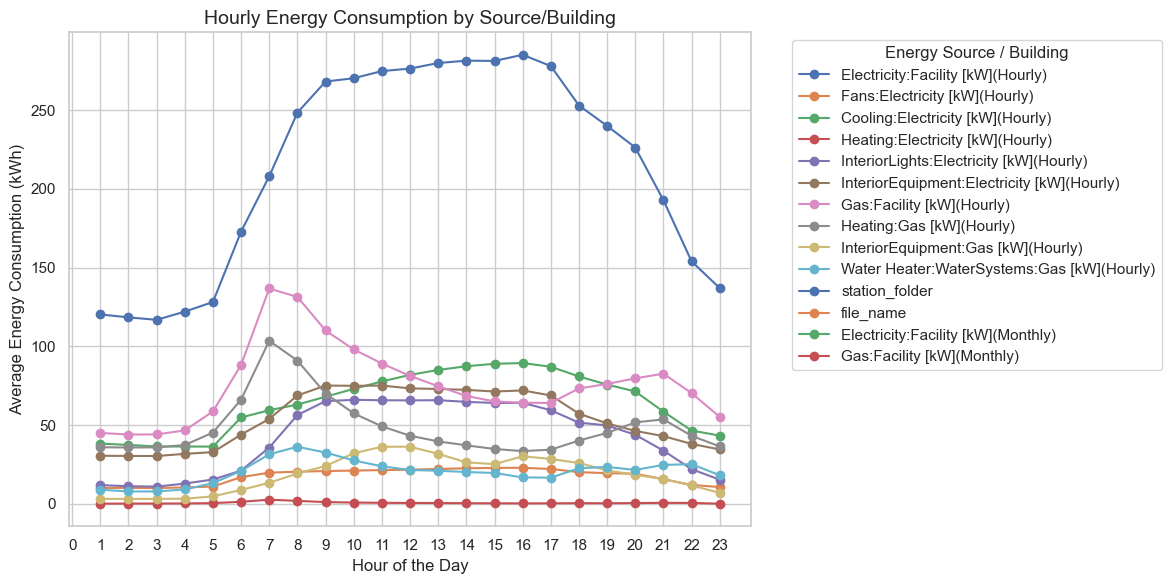

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Extract only energy columns (excluding Date/Time)
energy_cols = [col for col in df.columns if col != 'Date/Time' and col != 'energy_kwh']

# Group by hour and calculate mean for each energy column
hourly_energy = df.groupby(df['Date/Time'].dt.hour)[energy_cols].mean()

# Plot
plt.figure(figsize=(12, 6))
for col in hourly_energy.columns:
    plt.plot(hourly_energy.index, hourly_energy[col], marker='o', label=col)

# Labels and title
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Average Energy Consumption (kWh)", fontsize=12)
plt.title("Hourly Energy Consumption by Source/Building", fontsize=14)
plt.xticks(range(0, 24))
plt.legend(title="Energy Source / Building", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Highlight the peak hour per building

C:\Users\gupta\AppData\Local\Temp\ipykernel_12072\2840688162.py:22: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  building_peak_hour = hourly_energy[col].idxmax()
C:\Users\gupta\AppData\Local\Temp\ipykernel_12072\2840688162.py:22: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  building_peak_hour = hourly_energy[col].idxmax()
C:\Users\gupta\AppData\Local\Temp\ipykernel_12072\2840688162.py:22: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  building_peak_hour = hourly_energy[col].idxmax()
C:\Users\gupta\AppData\Local\Temp\ipykernel_12072\2840688162.py:22: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In

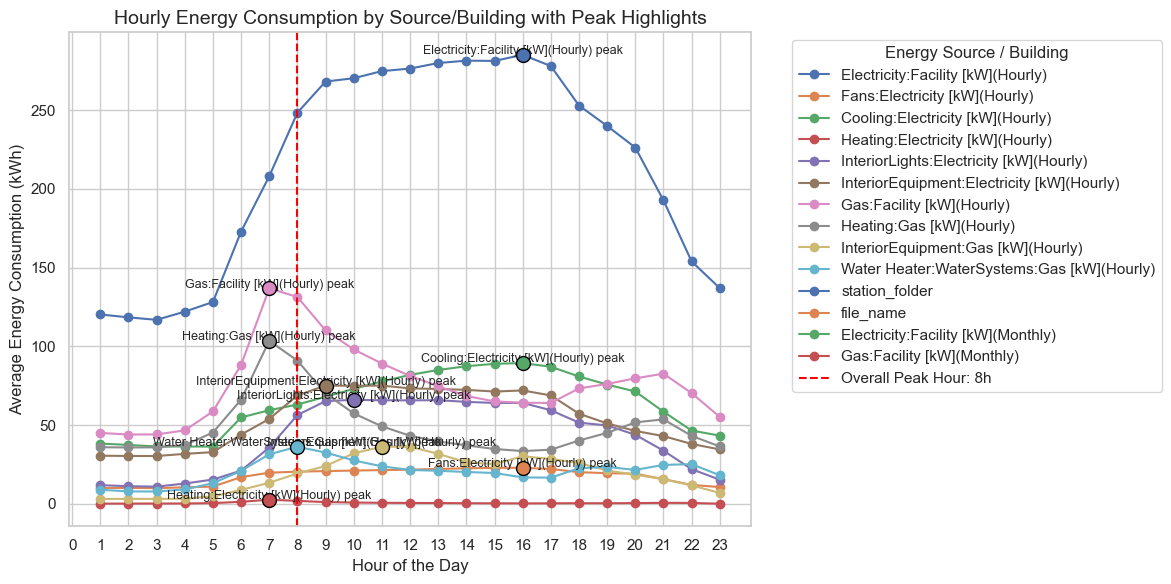

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Extract energy columns (excluding Date/Time and total)
energy_cols = [col for col in df.columns if col not in ['Date/Time', 'energy_kwh']]

# Group by hour and calculate mean for each energy column
hourly_energy = df.groupby(df['Date/Time'].dt.hour)[energy_cols].mean()

# Find overall peak hour
overall_peak_hour = df.groupby(df['Date/Time'].dt.hour)['energy_kwh'].mean().idxmax()

# Plot all energy sources
plt.figure(figsize=(12, 6))
for col in hourly_energy.columns:
    plt.plot(hourly_energy.index, hourly_energy[col], marker='o', label=col)
    
    # Highlight peak for this building
    building_peak_hour = hourly_energy[col].idxmax()
    plt.scatter(building_peak_hour, hourly_energy[col].max(), s=100, edgecolors='black', zorder=5)
    plt.text(building_peak_hour, hourly_energy[col].max()+0.5, f"{col} peak", ha='center', fontsize=9)

# Highlight overall peak hour
plt.axvline(overall_peak_hour, color='red', linestyle='--', label=f'Overall Peak Hour: {overall_peak_hour}h')

# Labels and title
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Average Energy Consumption (kWh)", fontsize=12)
plt.title("Hourly Energy Consumption by Source/Building with Peak Highlights", fontsize=14)
plt.xticks(range(0, 24))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Energy Source / Building")
plt.tight_layout()
plt.show()


# Stacked area chart showing cumulative energy per hour for all buildings/sources

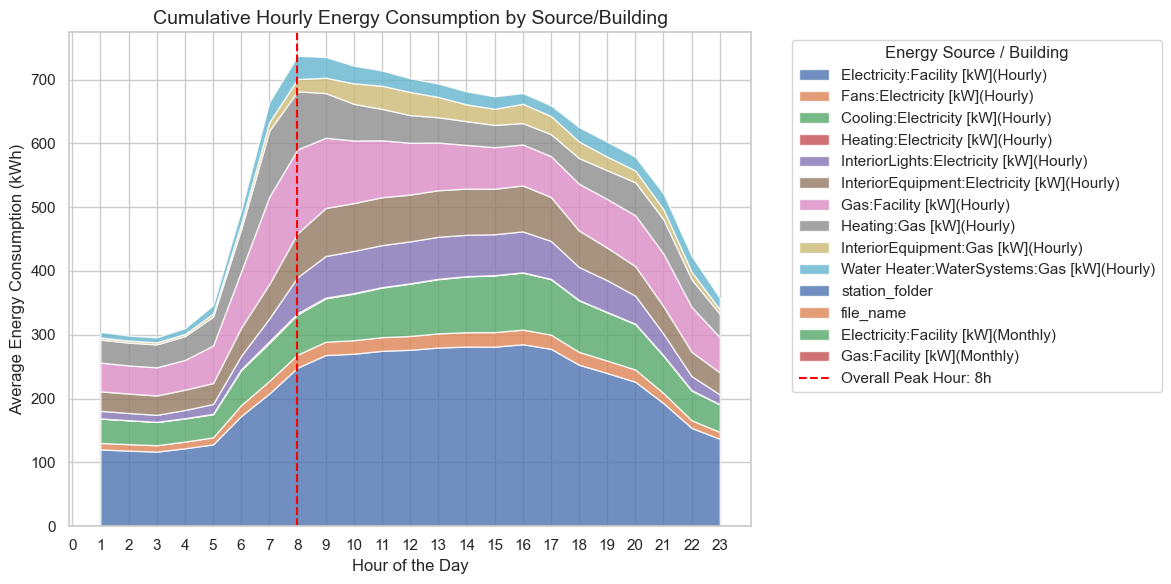

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Extract energy columns (excluding Date/Time and total)
energy_cols = [col for col in df.columns if col not in ['Date/Time', 'energy_kwh']]

# Group by hour and calculate mean for each energy column
hourly_energy = df.groupby(df['Date/Time'].dt.hour)[energy_cols].mean()

# Plot stacked area chart
plt.figure(figsize=(12, 6))
plt.stackplot(hourly_energy.index, hourly_energy.T, labels=hourly_energy.columns, alpha=0.8, cmap='viridis')

# Highlight overall peak hour
overall_peak_hour = df.groupby(df['Date/Time'].dt.hour)['energy_kwh'].mean().idxmax()
plt.axvline(overall_peak_hour, color='red', linestyle='--', label=f'Overall Peak Hour: {overall_peak_hour}h')

# Labels and title
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Average Energy Consumption (kWh)", fontsize=12)
plt.title("Cumulative Hourly Energy Consumption by Source/Building", fontsize=14)
plt.xticks(range(0, 24))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Energy Source / Building")
plt.tight_layout()
plt.show()


# Annotate the building that contributes most during the overall peak hour

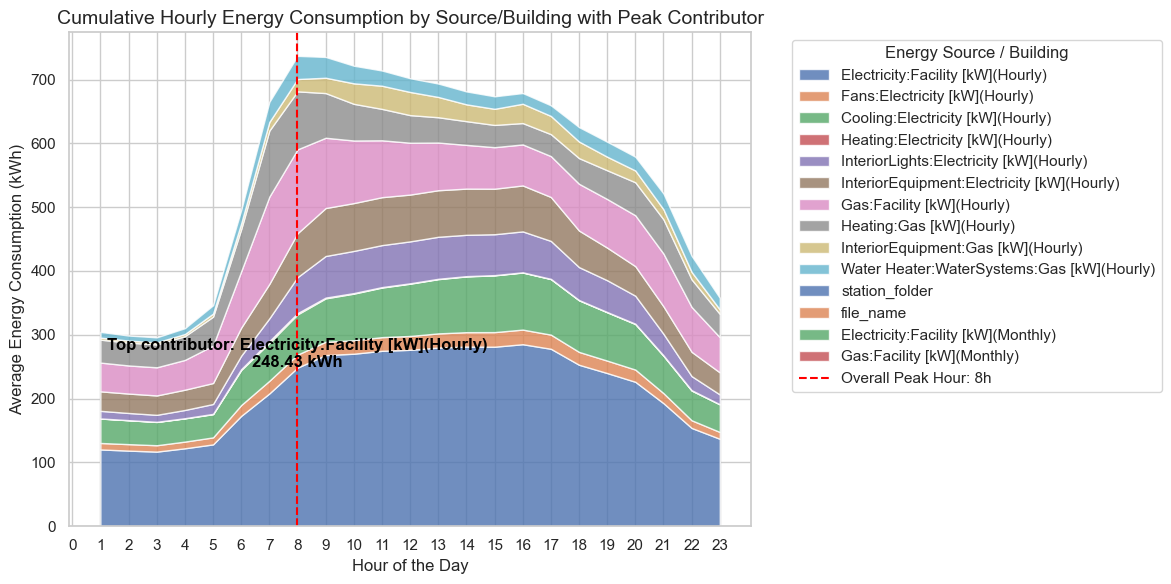

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Extract energy columns (excluding Date/Time and total)
energy_cols = [col for col in df.columns if col not in ['Date/Time', 'energy_kwh']]

# Group by hour and calculate mean for each energy column
hourly_energy = df.groupby(df['Date/Time'].dt.hour)[energy_cols].mean()

# Find overall peak hour
overall_peak_hour = df.groupby(df['Date/Time'].dt.hour)['energy_kwh'].mean().idxmax()

# Identify the building contributing most at the peak hour
peak_contributions = hourly_energy.loc[overall_peak_hour]
top_building = peak_contributions.idxmax()
top_value = peak_contributions.max()

# Plot stacked area chart
plt.figure(figsize=(12, 6))
plt.stackplot(hourly_energy.index, hourly_energy.T, labels=hourly_energy.columns, alpha=0.8, cmap='viridis')

# Highlight overall peak hour
plt.axvline(overall_peak_hour, color='red', linestyle='--', label=f'Overall Peak Hour: {overall_peak_hour}h')

# Annotate the top building at peak
plt.text(overall_peak_hour, top_value + 1, f"Top contributor: {top_building}\n{top_value:.2f} kWh",
         color='black', fontweight='bold', ha='center')

# Labels and title
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Average Energy Consumption (kWh)", fontsize=12)
plt.title("Cumulative Hourly Energy Consumption by Source/Building with Peak Contributor", fontsize=14)
plt.xticks(range(0, 24))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Energy Source / Building")
plt.tight_layout()
plt.show()


# Stacked area chart where we annotate each building’s individual peak hour

C:\Users\gupta\AppData\Local\Temp\ipykernel_12072\3121551720.py:25: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  building_peak_hour = hourly_energy[col].idxmax()
C:\Users\gupta\AppData\Local\Temp\ipykernel_12072\3121551720.py:25: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  building_peak_hour = hourly_energy[col].idxmax()
C:\Users\gupta\AppData\Local\Temp\ipykernel_12072\3121551720.py:25: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  building_peak_hour = hourly_energy[col].idxmax()
C:\Users\gupta\AppData\Local\Temp\ipykernel_12072\3121551720.py:25: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In

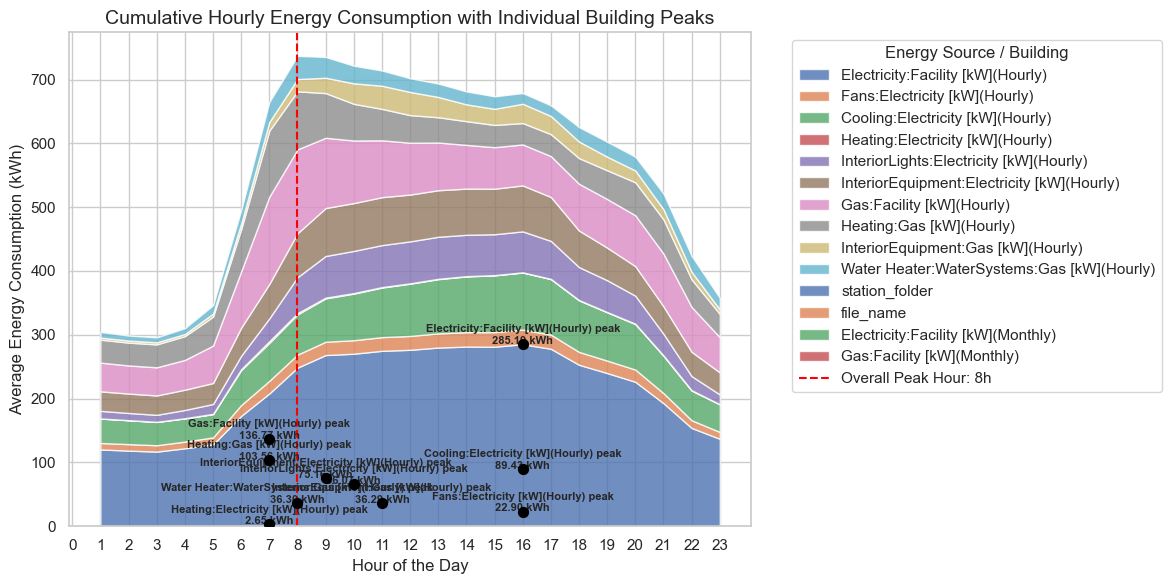

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Extract energy columns (excluding Date/Time and total)
energy_cols = [col for col in df.columns if col not in ['Date/Time', 'energy_kwh']]

# Group by hour and calculate mean for each energy column
hourly_energy = df.groupby(df['Date/Time'].dt.hour)[energy_cols].mean()

# Find overall peak hour
overall_peak_hour = df.groupby(df['Date/Time'].dt.hour)['energy_kwh'].mean().idxmax()

# Plot stacked area chart
plt.figure(figsize=(12, 6))
plt.stackplot(hourly_energy.index, hourly_energy.T, labels=hourly_energy.columns, alpha=0.8, cmap='viridis')

# Highlight overall peak hour
plt.axvline(overall_peak_hour, color='red', linestyle='--', label=f'Overall Peak Hour: {overall_peak_hour}h')

# Annotate each building's peak hour
for col in hourly_energy.columns:
    building_peak_hour = hourly_energy[col].idxmax()
    peak_value = hourly_energy[col].max()
    plt.scatter(building_peak_hour, peak_value, color='black', s=50, zorder=5)
    plt.text(building_peak_hour, peak_value + 0.5, f"{col} peak\n{peak_value:.2f} kWh",
             ha='center', fontsize=8, fontweight='bold')

# Labels and title
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Average Energy Consumption (kWh)", fontsize=12)
plt.title("Cumulative Hourly Energy Consumption with Individual Building Peaks", fontsize=14)
plt.xticks(range(0, 24))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Energy Source / Building")
plt.tight_layout()
plt.show()
